###  1. Разделите данные Титаника (train.csv) на тренировочную, валидационную и тестовую часть. С помощью валидационной части подберите гиперпараметры для моделей Random Forest, XGBoost, Logistic Regression и KNN. Получите точность этих моделей на тестовой части.

подготавливаем данные..

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('train.csv')

df_prep_x = df.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
df_prep_y = df['Survived']

def prepare_num(df):
    df_num = df.drop(['Sex', 'Embarked', 'Pclass'], axis=1)
    df_sex = pd.get_dummies(df['Sex'])
    df_emb = pd.get_dummies(df['Embarked'], prefix='Emb')
    df_pcl = pd.get_dummies(df['Pclass'], prefix='Pclass')

    df_num = pd.concat((df_num, df_sex, df_emb, df_pcl), axis=1)
    return df_num

df_prep_x_num = prepare_num(df_prep_x)

df_prep_x_num = df_prep_x_num.fillna(df_prep_x_num.median())
df_prep_y = df_prep_y.fillna(df_prep_y.median())

scaler = MinMaxScaler()
scaled_x = scaler.fit_transform(df_prep_x_num)

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_x, df_prep_y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

### RandomForestClassifier

In [79]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
best_acc, best_est, best_crit, best_max_depth = 0,0,[],0
criterion = ["gini","entropy","log_loss"]
for i in range(30):
     for j in range(10):
            for k in range(3):
                valid_model = RandomForestClassifier(n_estimators=i+1, criterion=criterion[k], max_depth=j+1)
                valid_model.fit(X_train, y_train)
                actual_acc = valid_model.score(X_val,y_val)
                if actual_acc > best_acc:
                        best_acc= actual_acc
                        best_est = i+1
                        best_crit = criterion[k]
                        best_max_depth=j+1

print("Лучшая точность во время валидации:", best_acc)
print("Достигается с параметрами n_estimators = %d, criterion = %s, max_depth = %d" % (best_est, best_crit, best_max_depth))

RandomForestModelValid = RandomForestClassifier(n_estimators=best_est, criterion=best_crit, max_depth=best_max_depth)
RandomForestModelValid.fit(X_train,y_train)
print("Точность на тестовых данных:", RandomForestModelValid.score(X_test,y_test))


Лучшая точность во время валидации: 0.8551401869158879
Достигается с параметрами n_estimators = 9, criterion = entropy, max_depth = 9
Точность на тестовых данных: 0.8268156424581006


### XGBoost

In [77]:
from xgboost import XGBClassifier
best_acc, best_est, best_max_depth = 0,0,0
for i in range(30):
     for j in range(10):
        valid_model = XGBClassifier(n_estimators=i+1, max_depth=j+1)
        valid_model.fit(X_train, y_train)
        actual_acc = valid_model.score(X_val,y_val)
        if actual_acc > best_acc:
                best_acc= actual_acc
                best_est = i+1
                best_max_depth=j+1

print("Лучшая точность во время валидации:", best_acc)
print("Достигается с параметрами n_estimators = %d, max_depth = %d" % (best_est, best_max_depth))

XGBClassifierModelValid = XGBClassifier(n_estimators=best_est, max_depth=best_max_depth)
XGBClassifierModelValid.fit(X_train,y_train)
print("Точность на тестовых данных:", XGBClassifierModelValid.score(X_test,y_test))

Лучшая точность во время валидации: 0.8504672897196262
Достигается с параметрами n_estimators = 7, max_depth = 7
Точность на тестовых данных: 0.8212290502793296


### LogisticRegression

In [101]:
from sklearn.linear_model import LogisticRegression
solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
best_acc, best_C, best_solver = 0,0,[]
for i in range(100):
     for j in range(6):
        valid_model = LogisticRegression(C=(i+1)/100, solver=solver[j])
        valid_model.fit(X_train, y_train)
        actual_acc = valid_model.score(X_val,y_val)
        if actual_acc > best_acc:
                best_acc= actual_acc
                best_C = (i+1)/100
                best_solver=solver[j]

print("Лучшая точность во время валидации:", best_acc)
print("Достигается с параметрами C = %f, solver = %s" % (best_C, best_solver))

LogisticRegressionModelValid = LogisticRegression(C=best_C, solver=best_solver)
LogisticRegressionModelValid.fit(X_train,y_train)
print("Точность на тестовых данных:", LogisticRegressionModelValid.score(X_test,y_test))

Лучшая точность во время валидации: 0.8177570093457944
Достигается с параметрами C = 0.010000, solver = liblinear
Точность на тестовых данных: 0.770949720670391


### KNN

In [109]:
from sklearn.neighbors import KNeighborsClassifier
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
best_acc, best_n, best_wei, best_alg = 0,0,[],[]
for i in range(10):
     for j in range(2):
        for k in range(4):
            valid_model = KNeighborsClassifier(n_neighbors=i+1, weights=weights[j],algorithm=algorithm[k])
            valid_model.fit(X_train, y_train)
            actual_acc = valid_model.score(X_val,y_val)
            if actual_acc >= best_acc:
                    best_acc= actual_acc
                    best_n = i+1
                    best_wei=weights[j]
                    best_alg=algorithm[k]

print("Лучшая точность во время валидации:", best_acc)
print("Достигается с параметрами n_neighbors = %d, weights = %s, algorithm = %s" % (best_n, best_wei,best_alg))

KNeighborsClassifierModelValid = KNeighborsClassifier(n_neighbors = best_n, weights=best_wei,algorithm=best_alg)
KNeighborsClassifierModelValid.fit(X_train,y_train)
print("Точность на тестовых данных:", KNeighborsClassifierModelValid.score(X_test,y_test))

Лучшая точность во время валидации: 0.8317757009345794
Достигается с параметрами n_neighbors = 8, weights = uniform, algorithm = brute
Точность на тестовых данных: 0.7597765363128491


### 2. С помощью RandomForest выберите 2, 4, 8 самых важных признаков и проверьте точность моделей только на этих признаках.

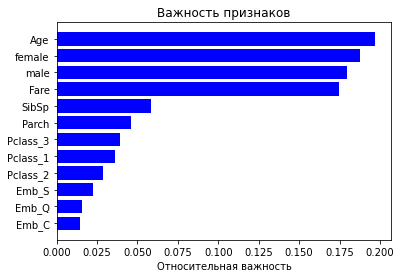

In [20]:
import matplotlib.pyplot as plt

importances = RandomForestModelValid.feature_importances_
features = df_prep_x_num.columns
indices = np.argsort(importances)

plt.title('Важность признаков')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Относительная важность')
plt.show()

In [73]:
df_prep_x2 = df_prep_x_num[['Age','female']]
scaled_x2 = MinMaxScaler().fit_transform(df_prep_x2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(scaled_x2, df_prep_y, test_size=0.2, random_state=1)
RandomForestModelValid = RandomForestClassifier(n_estimators=best_est, criterion=best_crit, max_depth=best_max_depth)
RandomForestModelValid.fit(X_train2,y_train2)
print("Точность на 2('Age','female') признаках:", RandomForestModelValid.score(X_test2,y_test2))

df_prep_x4 = df_prep_x_num[['Fare','Age','female','male']]
scaled_x4 = MinMaxScaler().fit_transform(df_prep_x4)
X_train4, X_test4, y_train4, y_test4 = train_test_split(scaled_x4, df_prep_y, test_size=0.2, random_state=1)
RandomForestModelValid = RandomForestClassifier(n_estimators=best_est, criterion=best_crit, max_depth=best_max_depth)
RandomForestModelValid.fit(X_train4,y_train4)
print("Точность на 4('Fare','Age','female','male') признаках:", RandomForestModelValid.score(X_test4,y_test4))

df_prep_x8 = df_prep_x_num[['Fare','Age','female','Parch','male','SibSp','Pclass_3','Pclass_1']]
scaled_x8 = MinMaxScaler().fit_transform(df_prep_x8)
X_train8, X_test8, y_train8, y_test8 = train_test_split(scaled_x8, df_prep_y, test_size=0.2, random_state=1)
RandomForestModelValid = RandomForestClassifier(n_estimators=best_est, criterion=best_crit, max_depth=best_max_depth)
RandomForestModelValid.fit(X_train8,y_train8)
print("Точность на 8('Fare','Age','female','Parch','male','SibSp','Pclass_3','Pclass_1') признаках:", RandomForestModelValid.score(X_test8,y_test8))

Точность на 2('Age','female') признаках: 0.7541899441340782
Точность на 4('Fare','Age','female','male') признаках: 0.8156424581005587
Точность на 8('Fare','Age','female','Parch','male','SibSp','Pclass_3','Pclass_1') признаках: 0.7988826815642458


### 3. Используя координаты скважин из файла wells_info.csv разделите их на кластера с помощью любых 4 методов и отобразите разделение. Параметры подбираются самостоятельно.

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('wells_info.csv')
coordinates = df[['BottomHoleLatitude','BottomHoleLongitude']]

#### KMeans

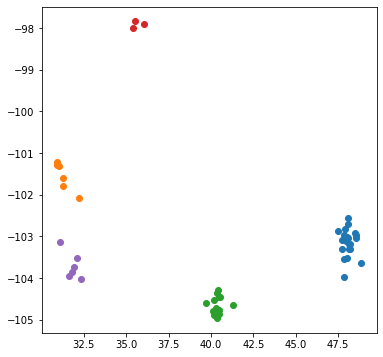

In [23]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=5)
clusters = model.fit_predict(coordinates.values)

plt.figure(figsize=(6, 6))
for cl in np.unique(clusters):
    data_ = coordinates.values[clusters == cl]
    plt.scatter(data_[:, 0], data_[:, 1])
plt.show()

#### DBSCAN

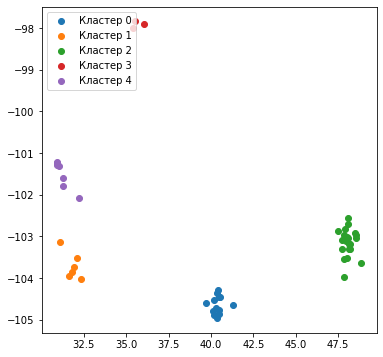

In [24]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=1, min_samples=1)
clusters = model.fit_predict(coordinates.values)

plt.figure(figsize=(6, 6))
for cl in np.unique(clusters):
    data_ = coordinates.values[clusters == cl]
    plt.scatter(data_[:, 0], data_[:, 1], label='Кластер {}'.format(cl))
plt.legend(loc=2)
plt.show()

#### Birch

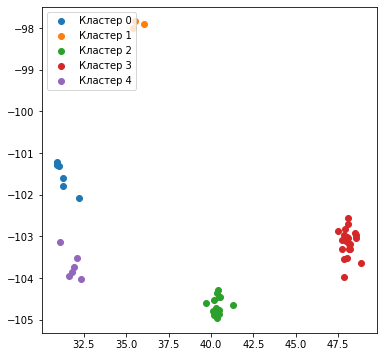

In [27]:
from sklearn.cluster import Birch

model = Birch(branching_factor = 60, n_clusters = 5, threshold = 1.0)
clusters = model.fit_predict(coordinates.values)

plt.figure(figsize=(6, 6))
for cl in np.unique(clusters):
    data_ = coordinates.values[clusters == cl]
    plt.scatter(data_[:, 0], data_[:, 1], label='Кластер {}'.format(cl))
plt.legend(loc=2)
plt.show()

#### OPTICS

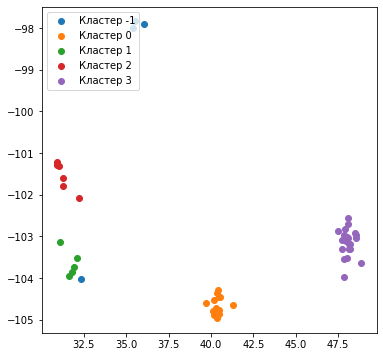

In [46]:
from sklearn.cluster import OPTICS

model = OPTICS(min_samples=6, max_eps=2, min_cluster_size=0.01)
clusters = model.fit_predict(coordinates.values)

plt.figure(figsize=(6, 6))
for cl in np.unique(clusters):
    data_ = coordinates.values[clusters == cl]
    plt.scatter(data_[:, 0], data_[:, 1], label='Кластер {}'.format(cl))
plt.legend(loc=2)
plt.show()

### 4. Приведите отобранные в 6.1 задании признаки из файла wells_info_with_prod.csv в двумерное пространство. Выделите цветом добычу с этой скважины.

In [3]:
df4 = pd.read_csv('wells.csv')
df4.head()

FileNotFoundError: [Errno 2] No such file or directory: 'wells.csv'